In [2]:
import os, sys, csv
from nilearn import masking
import nibabel as nb
from nibabel.affines import apply_affine
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
mpl.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from scipy import stats
#import mne
import numpy as np
import pandas as pd
from sklearn import linear_model
%matplotlib inline

# get gradient and concordance vectors for one subject

In [3]:
def distance_to_lesion(comp_file, concor_file, 
                       gm_file, les_file, model='spear'):

    COMP     = np.array(nb.load(comp_file).get_data())
    CONCOR   = np.array(nb.load(concor_file).get_data())
    
    gm_mask = nb.load(gm_file).get_data()
    x    = np.where(gm_mask==1)[0]
    y    = np.where(gm_mask==1)[1]
    z    = np.where(gm_mask==1)[2]

    COMPONENT   = COMP[x,y,z]
    CONCORDANCE = CONCOR[x,y,z]

    # where would be the lesion along the component
    lesion = np.array(nb.load(les_file).get_data())
    x_le   = np.where(lesion==1)[0]
    y_le   = np.where(lesion==1)[1]
    z_le   = np.where(lesion==1)[2]

    LESION = COMP[x_le, y_le, z_le]

    # define distance array
    d = np.zeros(len(COMPONENT))

    for i in range(0, len(COMPONENT)):        
            d[i] = min(abs(COMPONENT[i] - LESION))
    
    if model == 'spear':
        r, p = stats.spearmanr(d, CONCORDANCE)
    elif model == 'pear':
        r, p = stats.pearsonr(d, CONCORDANCE)
        
    return d, CONCORDANCE, COMPONENT, LESION, r, p

In [4]:
def plot_three_gradients_wilcox(rComps):

    fig = plt.figure(figsize=(11.7,11.7))
    ax1 = plt.subplot(1,1,1)
   
    sns.set(context="paper", 
            font="sans-serif", 
            font_scale=5.0,
            style="whitegrid",
            rc={"grid.linewidth": 5},
            palette='Set2'
            )
    
    sns.boxplot(data=rComps, 
                linewidth = 5,
                color='white',
                ax=ax1)
    
    #plt.setp(ax1.lines, color=".3")
    sns.swarmplot(data=rComps,
                  color='k',
                  size = 13,
                  ax=ax1)
    # one-tailed Wilcoxon signed-rank test 
    from scipy import stats
    popmean=0
    cols = ['Gradient 1',
            'Gradient 2',
            'Gradient 3']
    
    x_axis = 0.335
    for col in cols:        
        r    = rComps[col].median()
        
        t, p = stats.wilcoxon(np.array(rComps[col], dtype=float), 
                              y=None, zero_method='zsplit', 
                              correction=True)
        # one-tailed
        p = p
        
        if p < 0.05 and t > 0:
            fig.text(x_axis, 0.815, "*" % (p), fontname='sans-serif', 
                     size=73, rotation=0, backgroundcolor = 'white', color = 'k',
                     ha="center", va="center")
            
        x_axis += 0.24
    ax1.set(ylim=(-0.405, 0.604))
    ax1.set(ylabel='Spearman\'s correlation coefficients')
    fig.tight_layout()    
    return fig

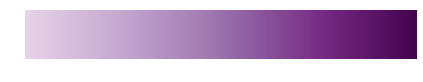

In [5]:
# colormap for scatter
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap = plt.get_cmap('PRGn')
new_cmap = truncate_colormap(cmap, 0.4, 0.01)
num = 256
gradient = range(num)
for x in range(5):
    gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap = new_cmap, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()
plt.show()

In [6]:
def plot_reg(d, CONCORDANCE, r_spearman, subject_id):
    
    ## get the slope and intercept of linear regression
    #slope, intercept, r_value, p_value, std_err = stats.linregress(d, CONCORDANCE)
    ## get regression line
    #line = slope*d + intercept
    ## plot scatter and regression line
    
    
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(22,7.5))
    plt.scatter(d, CONCORDANCE, c = CONCORDANCE, 
                vmin=-1.0, vmax=1.0, cmap = new_cmap)

    #plt.plot(d, line, 'k', linewidth=5.0)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    #plt.xlim(d.min(), d.max()+0.2)
    plt.ylim(-1, 1)
    plt.ylabel('concordance', fontsize = 25)
    plt.xlabel('distance to lesion side', fontsize = 25)
    plt.title('stroke subject, %s, (spearman = %.2f)' 
              %(subject_id, r_spearman), fontsize = 25)    
    return fig

## single patient - visualize relation between concordance and distance-to-lesion map (obtained on gradient 1)

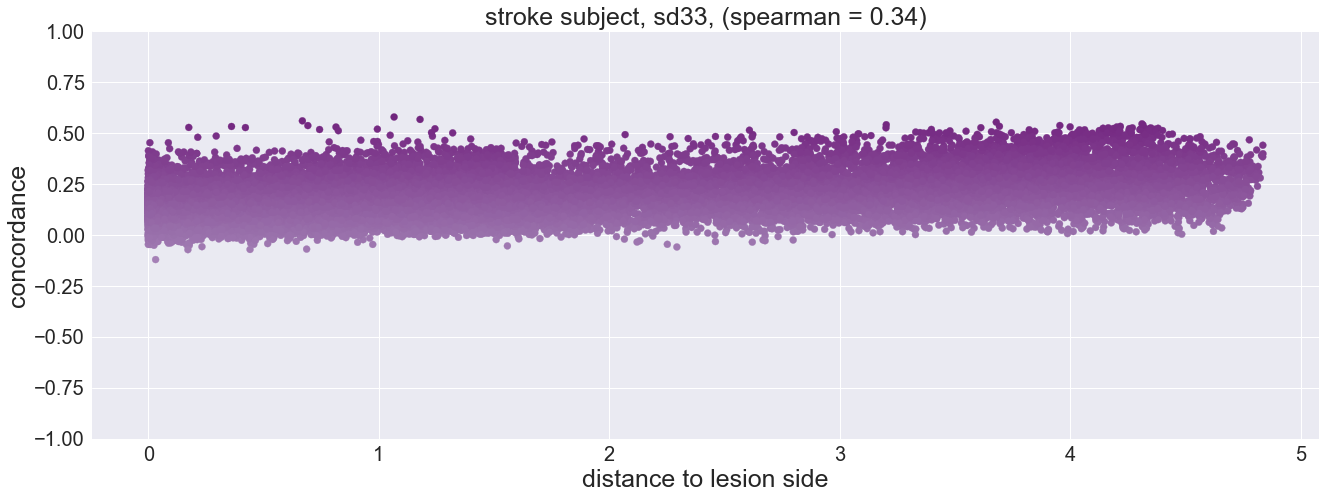

In [7]:
data_dir  = '/data/pt_mar006/subjects_masks/'
comp_file = '/data/pt_mar006/subjects_group/mni3_component_1.nii.gz'
concordance_file_name = 'conc_ccc.nii.gz'
subject_id = 'sd33'

concor_file = os.path.join(data_dir, subject_id, concordance_file_name)
gm_file     = os.path.join(data_dir, subject_id, 'gm_mask_no_lesion.nii.gz')
les_file    = os.path.join(data_dir, subject_id, 'lesion_mask_mni_gm.nii.gz')

d, CONCORDANCE, COMPONENT, LESION, r, p  = distance_to_lesion(comp_file,
                                                          concor_file,
                                                          gm_file,
                                                          les_file)

fig = plot_reg(d, CONCORDANCE, r, subject_id)


# group level: quantify the relation between concordance and lesion-to-gradient-distance maps

In [8]:
def get_df_all(concordance_file_name, data_dir, 
               comp_file_list, subject_list, 
               comp_columns, model = 'spear'): 
    
    rComps = pd.DataFrame(index=subject_list, 
                          columns=comp_columns)

    for comp_file in comp_file_list:
        
            col = 'comp_' + os.path.basename(comp_file[-8:-7])
      
            for subject_id in subject_list:              
                # get filenames...
                concor_file = os.path.join(data_dir, subject_id, 
                                           concordance_file_name)
                gm_file     = os.path.join(data_dir, subject_id, 
                                           'gm_mask_no_lesion.nii.gz')
                les_file    = os.path.join(data_dir, subject_id, 
                                           'lesion_mask_mni_gm.nii.gz')
                # run distance_to_lesion for each subject
                d, conc, comp, les, r, p  = distance_to_lesion(comp_file,
                                                           concor_file,
                                                           gm_file,
                                                           les_file,
                                                           model=model)
                rComps.ix[subject_id][col] = r
                #rComps.ix[subject_id][col + '_pval'] = "{:.6f}".format(p)
    return rComps

In [9]:
data_dir  = '/data/pt_mar006/subjects_masks/'

comp_file_list = ['/data/pt_mar006/components/mni3_component_1.nii.gz',
                  '/data/pt_mar006/components/mni3_component_2.nii.gz',
                  '/data/pt_mar006/components/mni3_component_3.nii.gz']

comp_columns = ['comp_1', #'comp_1_pval',
                'comp_2', #'comp_2_pval', 
                'comp_3', #'comp_3_pval']
                ]

list_name    = '/data/pt_mar006/documents/all_sd_after_qc_nohistory.txt'
with open(list_name) as f:
    subject_list = f.read().splitlines()

# concordance correlation coefficient (CCC)

In [10]:
df_ccc_spear = get_df_all('conc_ccc.nii.gz',
                           data_dir,
                           comp_file_list,
                           subject_list,
                           comp_columns,
                           model = 'spear')

/data/u_bayrak_software/anaconda2/envs/viz27/lib/python2.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


In [11]:
len(df_ccc_spear)

28

In [12]:
df_ccc_spear

,comp_1,comp_2,comp_3
sd02,0.163259,-0.278337,0.272443
sd05,0.143888,-0.0585291,0.298901
sd08,-0.0632316,0.152462,-0.13256
sd10,-0.010591,0.0449066,0.0873254
sd13,0.0351425,-0.0311335,0.166316
sd14,0.106863,-0.130274,0.1473
sd16,-0.194615,0.133681,0.10765
sd17,0.0916421,0.388081,0.0663102
sd21,0.0724997,0.0881166,0.184781
sd25,0.10327,0.124409,0.183804


In [13]:
rComps = df_ccc_spear

rComps = rComps.rename(columns={"comp_1": "Gradient 1",
                                "comp_2": "Gradient 2",
                                "comp_3": "Gradient 3"})


# plot distribution of correlations on individual gradients


0.7.1


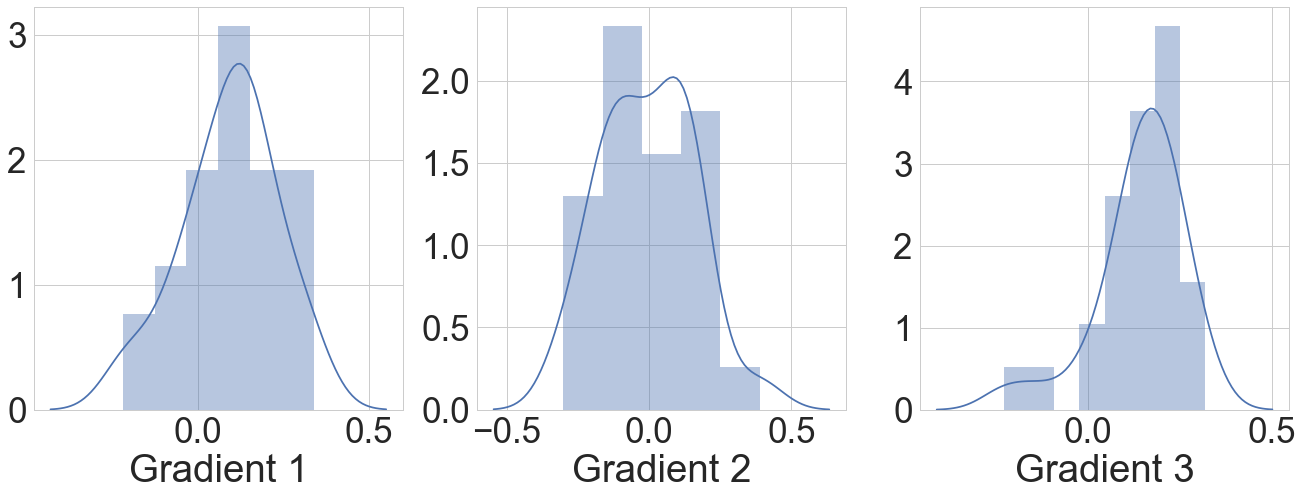

In [15]:
fig, ax = plt.subplots(figsize=(22.5,7), ncols=3, nrows=1)

left   =  0.125  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .2     # the amount of width reserved for blank space between subplots
hspace =  0.3   # the amount of height reserved for white space between subplots

plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace)

sns.set(font_scale=3.5)
sns.set_style("whitegrid")

sns.distplot(np.array(df_ccc_spear.comp_1, dtype=float), axlabel='Gradient 1', ax=ax[0])
sns.distplot(np.array(df_ccc_spear.comp_2, dtype=float), axlabel='Gradient 2', ax=ax[1])
sns.distplot(np.array(df_ccc_spear.comp_3, dtype=float), axlabel='Gradient 3', ax=ax[2])


print sns.__version__

# check if points normally distributed

In [16]:
# This function tests the null hypothesis that a sample comes from a normal distribution
# H0 = distribution is identical to a normal dist
stats.mstats.normaltest(np.array(df_ccc_spear.comp_1, dtype=float), axis=0)


NormaltestResult(statistic=1.0417277617720262, pvalue=0.5940071748110178)

In [17]:
stats.mstats.normaltest(np.array(df_ccc_spear.comp_2, dtype=float), axis=0)


NormaltestResult(statistic=0.17500324692880634, pvalue=0.9162173842033614)

In [18]:
stats.mstats.normaltest(np.array(df_ccc_spear.comp_3, dtype=float), axis=0)

NormaltestResult(statistic=13.19670091129068, pvalue=0.0013626138767609442)

# wilcoxon signed rank test

## Gradient 1

In [19]:
#The Wilcoxon signed-rank test tests the null hypothesis that two related paired samples come from 
#the same distribution. In particular, it tests whether the distribution of the differences x - y 
#is symmetric about zero. It is a non-parametric version of the paired T-test.

t, p = stats.wilcoxon(np.array(df_ccc_spear.comp_1, dtype=float), 
                      y=None, zero_method='zsplit', correction=True)

print "t and p : ", t, p
print "median: ", df_ccc_spear.comp_1.median(), 
print "mean: ", df_ccc_spear.comp_1.mean(), 
print "std: ", df_ccc_spear.comp_1.std()
print "max: ", rComps['Gradient 1'].max(),
print "min: ", rComps['Gradient 1'].min()


t and p :  71.0 0.002749471648198703
median:  0.10657911787431452 mean:  0.09287428991535611 std:  0.13978828911679347
max:  0.33982108021880864 min:  -0.2184580199738734


## Gradient 2

In [20]:
t, p = stats.wilcoxon(np.array(df_ccc_spear.comp_2, dtype=float), 
                      y=None, zero_method='zsplit', correction=True)

print "t and p : ", t, p
print "median: ", df_ccc_spear.comp_2.median(), 
print "mean: ", df_ccc_spear.comp_2.mean(), 
print "std: ", df_ccc_spear.comp_2.std()
print "max: ", rComps['Gradient 2'].max(),
print "min: ", rComps['Gradient 2'].min()

t and p :  189.0 0.7585281090215424
median:  -0.008814617399430942 mean:  -0.005256018332795498 std:  0.1619078324356771
max:  0.38808090962514463 min:  -0.30089504051465177


## Gradient 3

In [21]:
t, p = stats.wilcoxon(np.array(df_ccc_spear.comp_3, dtype=float), 
                      y=None, zero_method='zsplit', correction=True)

print "t and p : ", t, p
print "median: ", df_ccc_spear.comp_3.median(), 
print "mean: ", df_ccc_spear.comp_3.mean(), 
print "std: ", df_ccc_spear.comp_3.std()
print "max: ", rComps['Gradient 3'].max(),
print "min: ", rComps['Gradient 3'].min()

t and p :  35.0 0.0001366173689932883
median:  0.15825105022116204 mean:  0.14091360723376534 std:  0.12097653950957894
max:  0.31931493745023865 min:  -0.23041826318132047


In [22]:
rComps = df_ccc_spear

rComps = rComps.rename(columns={"comp_1": "Gradient 1",
                                "comp_2": "Gradient 2",
                                "comp_3": "Gradient 3"})


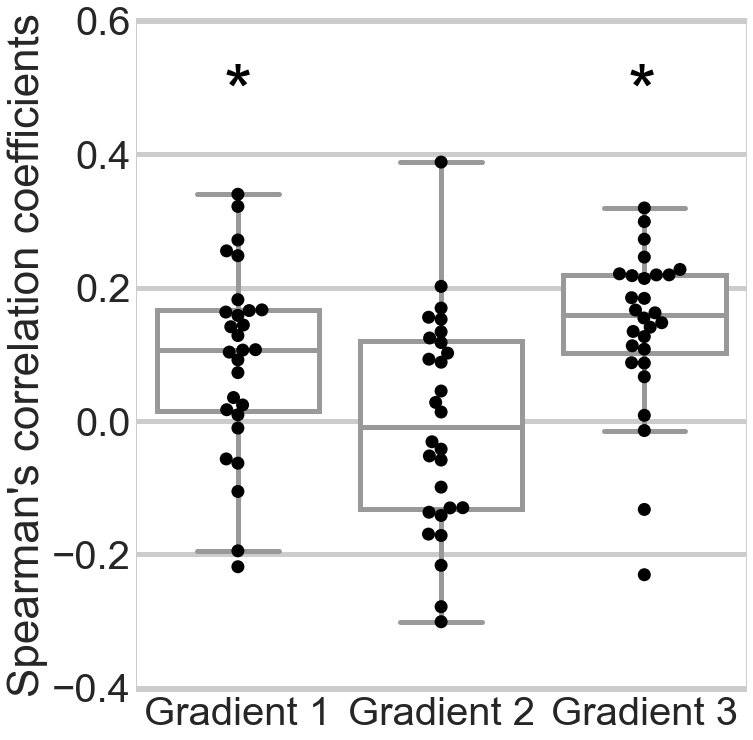

In [24]:
fig = plot_three_gradients_wilcox(rComps)